## The chamber data can compliment the flux data in a few ways

### 1) R$_e$ and GPP estimation

* Estimating ecosystem respiration (R$_e$) and gross primary production (GPP) from net ecosystem exchange (NEE) observations at Illisarvik in July & August is difficult using EC methods due to the limited number of nighttime observations.


* We need observations with little to no light (Photon Flux < 10 umol m$^-$$^2$ s$^-$$^1$) where it can be assumed that NEE = R$_e$ in order to approximate the relationship between soil temperature:

    * R$_e$= $\frac{1}{r_1 *r_2^T + r_3 }$
    * r$_1$ , r$_2$, and r$_3$ are fitted paramters and T is soil temperature
    
    
* However, we only have 94 such half hourly observations, which are heavilly skewed towards the latter portion of the observation period

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


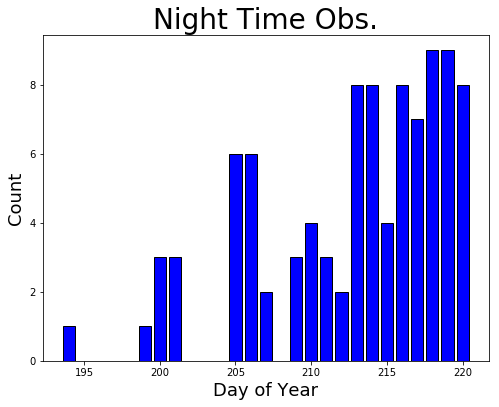

In [1]:
%matplotlib inline
# %matplotlib notebook


import sys
sys.path.append('C:/Users/wesle/Dropbox/Hacks')
import PltHacks as PH
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# import datetime as dt
from scipy.optimize import curve_fit
from scipy import stats
from sklearn import metrics

def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def P_func(PPFD,MQY,PM):
    cv =.7
    return(MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5/(2*cv))
def Line(X,m,b):
    return(m*X+b)
Path = 'C:/Illisarvik/QuickData.csv'
df = pd.read_csv(Path,delimiter = ',',header = 0)
df = df.set_index(pd.DatetimeIndex(df.datetime))
df = df.drop(df.columns[0],axis=1)
Data = df.astype(float)

Dark_Thresh = 10
Dark = Data[(Data['PPFD_Avg']<=Dark_Thresh)&(Data['co2_flux']>=0)]
Dark = Dark[['co2_flux','PPFD_Avg','Temp','ustar','VWC']].dropna()

# padding-left:3em;

DarkDays = Dark.groupby(Dark.index.dayofyear).count()
plt.figure(figsize = (8,6))
plt.bar(DarkDays.index,DarkDays['co2_flux'],edgecolor ='black',color = 'blue')
plt.xlabel('Day of Year',fontsize = 18)
plt.ylabel('Count',fontsize = 18)
plt.title('Night Time Obs.',fontsize = 28)
plt.show()


* Given this, the fit of the curve isn't great (r$^2$ = 0.33).  We don't have actual R$_e$ observations over the full range of soil temperatuers observed.  

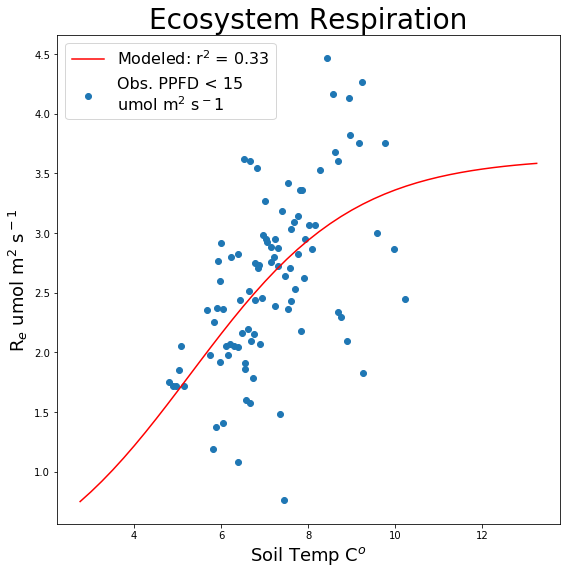

In [2]:
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['co2_flux'],p0=(1,1,1))
Data['R'] = Data['co2_flux']
Data.loc[Data['PPFD_Avg']>10,['R']]=np.nan
Data['R'] = Data['R'].fillna(R_func(Data['Temp'],*popt_r))
Data['GPP'] = (Data['R']-Data['co2_flux'])
P = Data[Data['PPFD_Avg']>=Dark_Thresh]
P = P[['GPP','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['GPP'],p0=(.003,12))
Data['GPP'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
Data['GPP_fill'] = P_func(Data['PPFD_Avg'],*popt_p)
Data['R_fill'] = R_func(Data['Temp'],*popt_r)

## Ordered Data for Plotting fits
Temp = np.arange(Data['Temp'].min(),Data['Temp'].max(),.25)
PAR = np.arange(Data['PPFD_Avg'].min(),Data['PPFD_Avg'].max(),1)

## Calculate r2
Rsq_Resp = metrics.explained_variance_score(Dark['co2_flux'].values,R_func(Dark['Temp'],*popt_r))
Rsq_GPP = metrics.explained_variance_score(P['GPP'].values,P_func(P['PPFD_Avg'],*popt_p))

fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize = (9,9))
axes.scatter(Dark['Temp'],Dark['co2_flux'],label = 'Obs. PPFD < 15\numol m$^2$ s$^-1$')
axes.plot(Temp,R_func(Temp,*popt_r),color = 'red',label = 'Modeled: r$^2$ = '+str(np.round(Rsq_Resp,2)))
axes.legend(loc = 2,fontsize = 16)
axes.set_ylabel('R$_e$ umol m$^2$ s$^-$$^1$',fontsize = 18)
axes.set_xlabel('Soil Temp C$^o$',fontsize = 18)
axes.set_title('Ecosystem Respiration',fontsize = 28)
plt.show()

* This then translates into a less than ideal estimate of GPP:

    * GPP = R$_e$ - NEE
    
    
* We'd like to fit GPP to a light response curve for gap filling:

    * GPP = p$_1$*PPFD + p$_2$ - ((p$_1$*PPFD + p$_2$)$^2$ - 4*c*p$_1$*PPFD*p$_2$)$^\frac{.5}{2*c}$
    * p$_1$ and p$_2$ are fitted coeficients and c = .7
    

* The GPP model fit is much better, but it would still be a better estimation if we had a better estimate of R$_e$


* We could use the CO$_2$ chamber observations to help train and validate the respiration estimates.

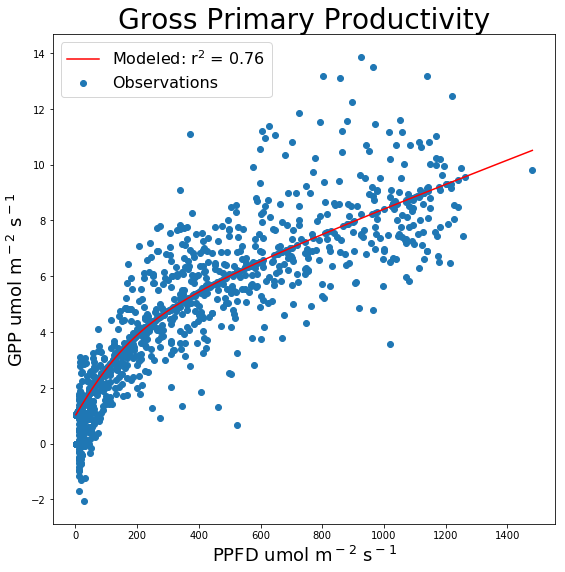

In [3]:
fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize = (9,9))
axes.scatter(Data['PPFD_Avg'],Data['GPP'],label = 'Observations')
axes.plot(PAR,P_func(PAR,*popt_p),color = 'red',label = 'Modeled: r$^2$ = '+ str(np.round(Rsq_GPP,2)))
axes.legend(loc = 2,fontsize = 16)
axes.set_ylabel('GPP umol m$^-$$^2$ s$^-$$^1$',fontsize = 18)
axes.set_xlabel('PPFD umol m$^-$$^2$ s$^-$$^1$',fontsize = 18)
axes.set_title('Gross Primary Productivity',fontsize = 28)
plt.show()

Data['NEEFill'] = Data['R_fill']-Data['GPP_fill']
Data['co2_filled'] = Data['co2_flux'].fillna(Data['NEEFill'])


### 2) Gap filling & validation

* The data sets have quite a few gaps for various reasons eg. rain or insuficient turbulent mixing

* The CO$_2$ flux time series can be filled reasonably well by estimating GPP and RE
    * If we can refine the R&_e$ estimates with the chamber observations, I think this method of gap filling will suffice


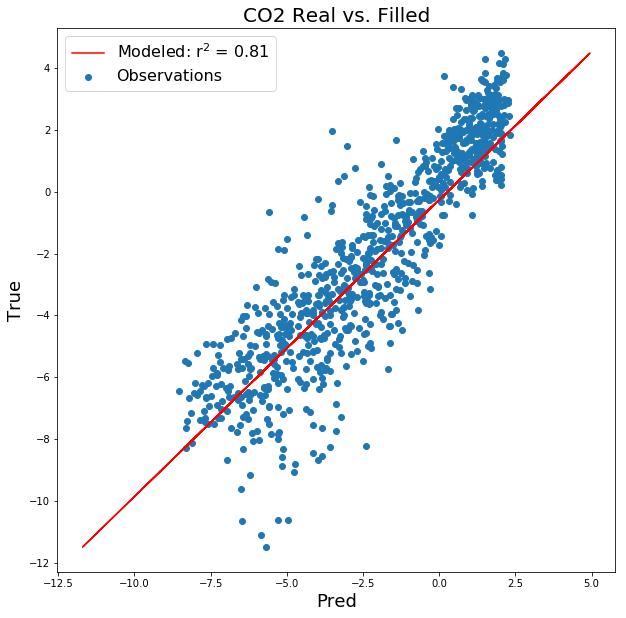

In [4]:

Y = Data[['co2_flux','NEEFill']].dropna()
popt_p, pcov = curve_fit(Line,Y['NEEFill'],Y['co2_flux'],p0=(1,1))
Y['Pred'] = Line(Y['co2_flux'],*popt_p)
Rsq_CO2 = metrics.explained_variance_score(Y['co2_flux'].values,Y['NEEFill'].values)

plt.figure(figsize = (10,10))
plt.scatter(Data['NEEFill'],Data['co2_flux'],label = 'Observations')
plt.plot(Y['Pred'],Y['co2_flux'],label = 'Modeled: r$^2$ = '+ str(np.round(Rsq_CO2,2)),color = 'red')
plt.ylabel('True',fontsize = 18)
plt.xlabel('Pred',fontsize = 18) 
plt.title('CO2 Real vs. Filled',fontsize = 20)

plt.legend(loc = 2,fontsize = 16)
plt.show()

* The CH$_4$ fluxes are far more difficult to model due to the strong influence of source area and non linear relationships with explanitory varriables.

    * I've calculated the footprint of each observation using Klujn et al. 2011 and referenced it to a map I created based off Tony's drone imagery and a rough map Alice shared w/ me.

![title](PaperMapTest.png)


* CH$_4$ fluxes were heavily dependent upon the amount of sedge within the footprint.

* To gapfill the time sereis I've decided to use Neural Networks (a type of machine learing) to tackle this problem and have gotten a reasonably good fit.
    
    * The below model acounts for both source distribution 
    
    * If I we can add the chamber flux observations to the model, it may help improve the fit.

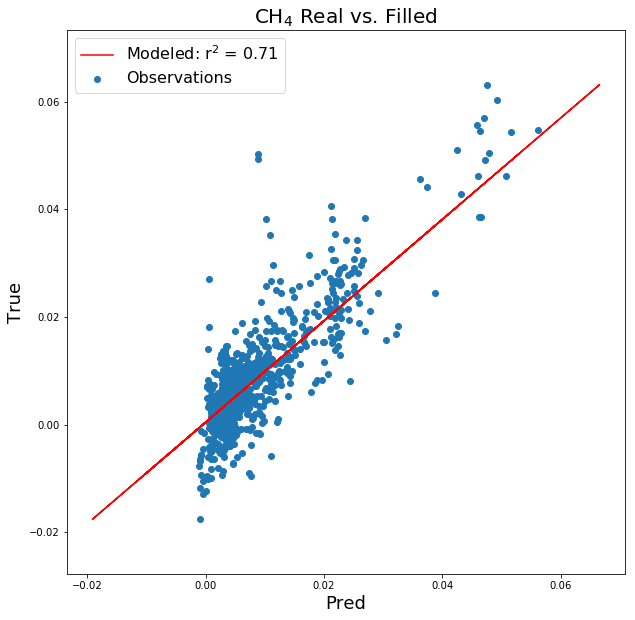

In [5]:
from sklearn.neural_network import MLPRegressor as MPR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from multiprocessing import Pool
from functools import partial
    

CH4Model = ['ch4_flux','Sedge','Shrubby','Temp','VWC']#,'AirTC_Avg','ustar','air_pressure']  # 4 Nodes

def RepRunner(i,j,X,X_fill,y):
    Scale = StandardScaler()
    Scaled = Scale.fit(y.reshape(-1, 1))
    Yscale = Scaled.transform(y.reshape(-1, 1))
    y = np.ndarray.flatten(Yscale)
    NN = Pipeline([('scaling', StandardScaler()), ('MPR',  MPR(hidden_layer_sizes=(j),max_iter =1000
      ,activation='logistic',solver ='lbfgs',learning_rate = 'adaptive',warm_start = True
      ,early_stopping=True,tol=1e-6,validation_fraction=.33,random_state = i))])
    NN.fit(X,y)
    y_fill = NN.predict(X_fill)
#     y_pred = NN.predict(X)
    y_fill = Scaled.inverse_transform(y_fill.reshape(-1,1)).flatten()
    return(y_fill)

Model = CH4Model
Data[Model[1:]] =Data[Model[1:]].interpolate().bfill()

Train = Data[np.isnan(Data[Model[0]])==False]
X = Train[Model[1:]]
X_fill = Data[Model[1:]]
y = Train[Model[0]].values
seed = 1
size = 5
reps = 25

for i in range(reps):
    if i == 0:
        y_fill = RepRunner(i,j=size,X=X,X_fill=X_fill,y=y)
    else:
        y_fill += RepRunner(i,j=size,X=X,X_fill=X_fill,y=y)
        
y_fill = y_fill/(i+1)


Data['ch4_filler'] = y_fill
Data['ch4_filled'] = Data['ch4_flux'].fillna(Data['ch4_filler'])

Test = Data[['ch4_flux','ch4_filler']].dropna()
# print('Average Fit: ',metrics.explained_variance_score(Test['ch4_flux'],Test['ch4_filler']))



Y = Data[['ch4_flux','ch4_filler']].dropna()
popt_p, pcov = curve_fit(Line,Y['ch4_filler'],Y['ch4_flux'],p0=(1,1))
Y['Pred'] = Line(Y['ch4_flux'],*popt_p)
Rsq_CH4 = metrics.explained_variance_score(Y['ch4_flux'].values,Y['ch4_filler'].values)

plt.figure(figsize = (10,10))
plt.scatter(Data['ch4_filler'],Data['ch4_flux'],label = 'Observations')
plt.plot(Y['Pred'],Y['ch4_flux'],label = 'Modeled: r$^2$ = '+ str(np.round(Rsq_CH4,2)),color = 'red')

plt.ylabel('True',fontsize = 18)
plt.xlabel('Pred',fontsize = 18) 
plt.title('CH$_4$ Real vs. Filled',fontsize = 20)
plt.legend(loc = 2, fontsize = 16)
plt.show()

* You can see the gapfilling procedure has a relatively large impact on the flux estimates.

    * The EC observations seem to overestimate the fluxes a bit

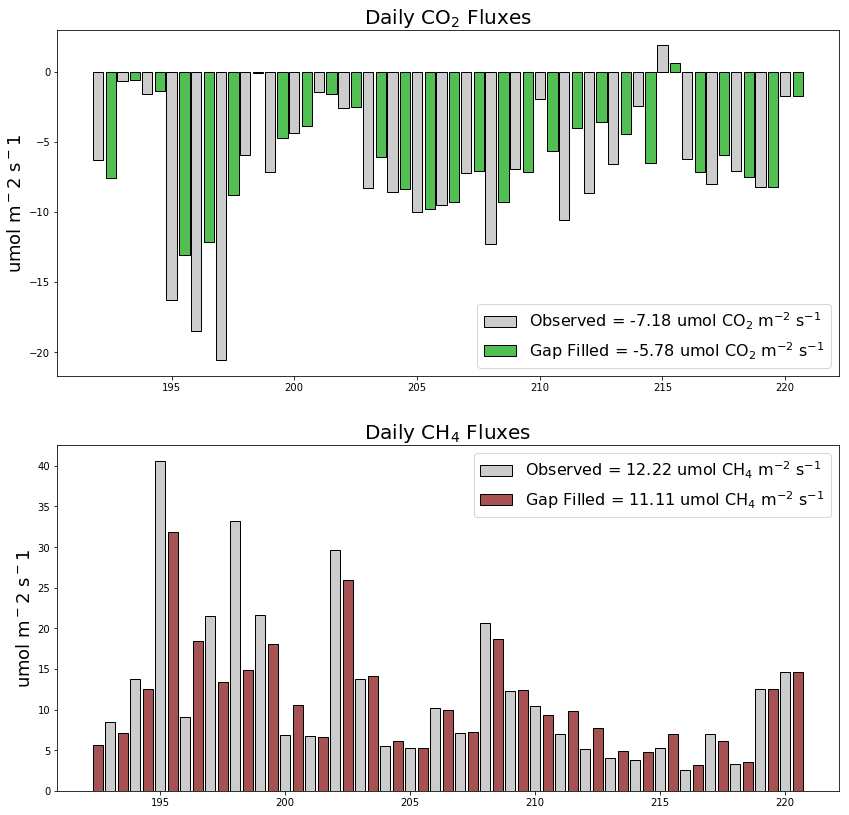

In [6]:
light_grey = [.8,.8,.8]
lr = [.65,.32,.32]
lg = [.32,.75,.32]



co2conv = 1e-6* 44.0095 *3600*24
ch4conv = 1e-3* 16.04246 *3600*24
Daily = Data.groupby(Data.index.dayofyear).mean()

fig,axes = plt.subplots(nrows = 2,ncols = 1,figsize = (14,14))

axes[0].bar(Daily.index,Daily['co2_flux']*co2conv,
            width = 0.42,color = light_grey,edgecolor = 'black',
            label = 'Observed = '+str(np.round(Daily['co2_flux'].mean()*co2conv,2))+' umol CO$_2$ m$^{-2}$ s$^{-1}$')
axes[0].bar(Daily.index+.52,Daily['co2_filled']*co2conv,
            width = 0.42,color = lg,edgecolor = 'black',
            label='Gap Filled = '+str(np.round(Daily['co2_filled'].mean()*co2conv,2))+' umol CO$_2$ m$^{-2}$ s$^{-1}$')
axes[0].legend(loc = 4,fontsize = 16)
axes[0].set_ylabel('umol m$^-2$ s$^-1$',fontsize = 18)
axes[0].set_title('Daily CO$_2$ Fluxes',fontsize = 20)

axes[1].bar(Daily.index,Daily['ch4_flux']*ch4conv,#*28,
            width = 0.42,color = light_grey,edgecolor = 'black',
            label = 'Observed = '+str(np.round(Daily['ch4_flux'].mean()*ch4conv,2))+' umol CH$_4$ m$^{-2}$ s$^{-1}$')
axes[1].bar(Daily.index+.52,Daily['ch4_filled']*ch4conv,#*28,
            width = 0.42,color = lr,edgecolor = 'black',
            label = 'Gap Filled = '+str(np.round(Daily['ch4_filled'].mean()*ch4conv,2))+' umol CH$_4$ m$^{-2}$ s$^{-1}$')
axes[1].legend(fontsize = 16)
axes[1].set_ylabel('umol m$^-2$ s$^-1$',fontsize = 18)
axes[1].set_title('Daily CH$_4$ Fluxes',fontsize = 20)
plt.show()

### 3) Upscaling

* I think it would be interesting to upscale our flux estimates to the basin scale.

    * Obviously, the flux footprint is not fully representative of the basin as a whole, but here what we observed:

38.4733771002
-197.030233223 -120.083479023


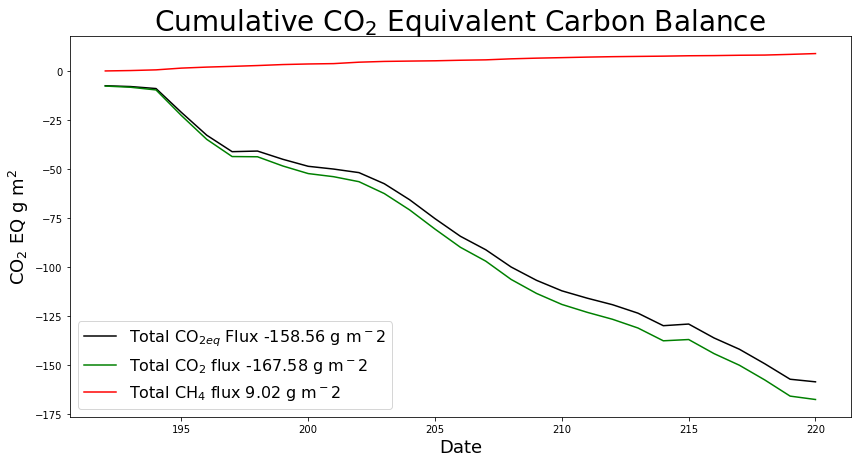

In [8]:
import statsmodels.stats.api as sms

Daily['Ballance'] = (Daily['co2_filled']* 1e-6 * 44.0095 *3600*24+
          Daily['ch4_filled']*28* 1e-6* 16.04246 *3600*24)

CI = sms.DescrStatsW(Daily['Ballance']).tconfint_mean()
print((CI[1]-CI[0])/2*Daily['Ballance'].count())
print(CI[0]*Daily['Ballance'].count(),CI[1]*Daily['Ballance'].count())

plt.figure(figsize = (14,7))
plt.plot((Daily['co2_filled'].cumsum()* co2conv+Daily['ch4_filled'].cumsum()*28*1e-3* ch4conv),color = 'black',
         label = 'Total CO$_{2eq}$ Flux '+ str(np.round(Daily['co2_filled'].sum()* co2conv+Daily['ch4_filled'].sum()*28*1e-3* ch4conv,2))+' g m$^-2$')
# plt.plot((Daily['co2_flux'].cumsum()* co2conv+Daily['ch4_flux'].cumsum()*28*1e-3* ch4conv),color = 'grey',
#          label = 'Total Carbon Flux '+ str(np.round(Daily['co2_flux'].sum()* co2conv+Daily['ch4_flux'].sum()*28*1e-3* ch4conv,2))+' g m$^-2$')

plt.plot(Daily['co2_filled'].cumsum()* co2conv,color = 'green',
        label = 'Total CO$_2$ flux ' + str(np.round(Daily['co2_filled'].sum()* co2conv,2))+' g m$^-2$')
plt.plot(Daily['ch4_filled'].cumsum()*28*1e-3* ch4conv,color = 'red',
         label = 'Total CH$_4$ flux ' + str(np.round(Daily['ch4_filled'].sum()*28*1e-3* ch4conv,2))+' g m$^-2$')
plt.legend(fontsize = 16)


plt.xlabel('Date',fontsize = 18)
plt.ylabel('CO$_2$ EQ g m$^2$',fontsize = 18)
plt.title('Cumulative CO$_2$ Equivalent Carbon Balance',fontsize = 28)
plt.show()

* From what we've obswerved, Illisarvik looks to be a strong carbon sink durring the growing season (which makes snese considering how much biomas has accumulated in the last 40 years).

    * At least where the tripod was located, CH$_4$ contributed relatively little to the overall carbon flux.  If the chamber results generally agree, we can estimate a ballpark figure for the whole basin.
    
    * Andreas & I have the idea of training a Neural Network to estimate fluxes at the basin scale based off the observed climate data and calculated source areas, then running it using the same climate data, but with the source distribution fixed to that of the basin

In [ ]:

# %%html
# <style>
# div.input {
#     display:none;
# }



from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-right:3em;
}

div.input {
    display:none;
}

</style>
""")

